# **Bước 1: Khởi tạo, Đọc Dữ liệu và Làm sạch Cơ bản**
Mục đích: Tải các thư viện cần thiết, đọc file CSV và chỉ giữ lại các cột liên quan.

In [96]:
# SỬA LỖI TỪ ĐOẠN CODE GỐC CỦA BẠN:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

# --- Tải Gói Ngôn ngữ (Sửa lỗi tải) ---
try:
    # 1. Tải Gói Stopwords
    stopwords.words('english')
except LookupError:
    print("Đang tải gói 'stopwords'...")
    nltk.download('stopwords')

try:
    # 2. Tải Gói Punkt (Cần cho Tokenization)
    nltk.word_tokenize('test')
except LookupError:
    print("Đang tải gói 'punkt'...")
    nltk.download('punkt') 
# ----------------------------------------------------
    
english_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()
# ----------------------------------------------------

CSV_FILE_PATH = r'D:\DataMining\Data\amazon_books_Data.csv'
REQUIRED_COLUMNS = [
    'market_place', 'customer_id', 'review_id', 'product_id', 
    'product_parent', 'product_title', 'product_category', 
    'star_rating', 'helpful_votes', 'total_votes', 
    'review_headline', 'review_body', 'review_date'
]

try:
    # Đọc tệp CSV và chỉ lấy các cột cần thiết
    df = pd.read_csv(CSV_FILE_PATH, encoding='utf-8', usecols=REQUIRED_COLUMNS)
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce') 
    df.dropna(subset=['review_date', 'customer_id', 'star_rating', 'review_body'], inplace=True) 

    print(f"Bước 1 Hoàn tất: Đã đọc và lọc {df.shape[0]} bản ghi.")
    print(f"5 bản ghi đầu tiên:")
    print(df.head())
    
except Exception as e:
    print(f"LỖI: KHÔNG ĐỌC ĐƯỢC DỮ LIỆU: {e}")
    df = pd.DataFrame() 
    raise SystemExit("Chương trình dừng vì lỗi đọc dữ liệu.")

Bước 1 Hoàn tất: Đã đọc và lọc 100 bản ghi.
5 bản ghi đầu tiên:
  market_place customer_id         review_id    product_id product_parent  \
0         "US"  "25933450"   "RJOVP071AVAJO"  "0439873800"     "84656342"   
1         "US"   "1801372"  "R1ORGBETCDW3AI"  "1623953553"    "729938122"   
2         "US"   "5782091"   "R7TNRFQAOUTX5"  "142151981X"    "678139048"   
3         "US"  "32715830"  "R2GANXKDIFZ6OI"  "014241543X"    "712432151"   
4         "US"  "14005703"  "R2NYB6C3R8LVN6"  "1604600527"    "800572372"   

                                    product_title product_category  \
0  "There Was an Old Lady Who Swallowed a Shell!"          "Books"   
1                                "I Saw a Friend"          "Books"   
2                          "Black Lagoon, Vol. 6"          "Books"   
3                                     "If I Stay"          "Books"   
4                       "Stars 'N Strips Forever"          "Books"   

   star_rating  helpful_votes  total_votes  \
0     

# Sửa Lỗi Tải NLTK

In [97]:
import nltk
import ssl

# Khắc phục lỗi SSL nếu bạn gặp vấn đề kết nối
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Tải thủ công các gói cần thiết
print("Bắt đầu tải NLTK resources...")
try:
    # Tải stopwords (kiểm tra lần nữa cho chắc chắn)
    nltk.download('stopwords', quiet=True) 
    # Tải gói punkt (thường khắc phục lỗi punkt_tab)
    nltk.download('punkt', quiet=True) 
    # Tải trực tiếp 'punkt_tab' theo đề xuất của lỗi (phòng trường hợp cần thiết)
    nltk.download('punkt_tab', quiet=True) 
    print("Tải NLTK resources hoàn tất.")
except Exception as e:
    print(f"LỖI KHI TẢI NLTK: {e}")

Bắt đầu tải NLTK resources...
Tải NLTK resources hoàn tất.


## **2. Làm sạch Dữ liệu Văn bản Nâng cao (NLP Preprocessing)**
Mục đích: Chuẩn hóa nội dung đánh giá (review_body) theo yêu cầu: loại bỏ ký tự không cần thiết, tách từ, loại bỏ stopwords và đưa từ về dạng gốc (Stemming).

In [98]:
# Hàm làm sạch dữ liệu văn bản chi tiết
def advanced_clean_text(text):
    # Kiểm tra giá trị thiếu (NaN)
    if pd.isna(text): 
        return ""
    
    # 1. Chuẩn hóa ngôn ngữ: Chuyển toàn bộ về chữ thường, loại bỏ URL, số
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Loại bỏ URL
    text = re.sub(r'[^\w\s]', '', text) # Loại bỏ dấu câu và ký tự đặc biệt
    text = re.sub(r'\d+', '', text) # Loại bỏ số
    
    # 2. Tách từ (Tokenization) - Dùng nltk.word_tokenize()
    tokens = nltk.word_tokenize(text)
    
    # 3. Loại bỏ stopwords: Dùng tập từ dừng tiếng Anh
    tokens = [w for w in tokens if w not in english_stopwords]
    
    # 4. Chuẩn hóa từ vựng (Stemming): Đưa từ về dạng gốc (ví dụ: 'running' -> 'run')
    tokens = [stemmer.stem(w) for w in tokens]
    
    # Kết quả là chuỗi các từ khóa đã làm sạch, ngăn cách bằng khoảng trắng
    return " ".join(tokens)

# Áp dụng hàm làm sạch lên cột review_body
df['cleaned_review'] = df['review_body'].apply(advanced_clean_text)

print("\nBước 2 Hoàn tất: Đã làm sạch và chuẩn hóa toàn bộ dữ liệu văn bản.")


Bước 2 Hoàn tất: Đã làm sạch và chuẩn hóa toàn bộ dữ liệu văn bản.


## **3. Tổng hợp Dữ liệu và Kỹ thuật Đặc trưng (Feature Aggregation)**
Mục đích: Tổng hợp dữ liệu cấp đánh giá thành dữ liệu cấp khách hàng (customer_id) và tạo các chỉ số hành vi (RFM, Avg Rating, Helpful Ratio).

In [99]:
# Đảm bảo các thư viện đã được import: import pandas as pd, import numpy as np, import re, ...

# Xác định ngày hiện tại giả định để tính Recency
today = df['review_date'].max() + pd.Timedelta(days=1)

user_features = df.groupby('customer_id').agg(
    # Hành vi: Frequency
    Frequency=('review_id', 'count'), 
    # Định lượng: Average Rating
    Avg_Rating=('star_rating', 'mean'),
    # Định lượng: Tổng Votes
    Total_Helpful_Votes=('helpful_votes', 'sum'),
    Total_Votes=('total_votes', 'sum'),
    # Hành vi: Recency
    Last_Review_Date=('review_date', 'max'),
    # Sở thích: Hợp nhất Văn bản ĐÃ LÀM SẠCH
    Full_Cleaned_Text=('cleaned_review', lambda x: ' '.join(x.astype(str))),
    # Sở thích: Danh mục Phổ biến nhất
    Most_Frequent_Category=('product_category', lambda x: x.mode()[0])
).reset_index()

# ⚠️ Lọc bỏ khách hàng chỉ có 1 đánh giá (Frequency <= 1)
user_features = user_features[user_features['Frequency'] > 1] 

# Tính Recency và Helpful Ratio
user_features['Recency'] = (today - user_features['Last_Review_Date']).dt.days
user_features['Helpful_Ratio'] = np.where(
    user_features['Total_Votes'] > 0,
    user_features['Total_Helpful_Votes'] / user_features['Total_Votes'],
    0
)
# Loại bỏ các cột phụ trợ
user_features.drop(columns=['Last_Review_Date', 'Total_Helpful_Votes', 'Total_Votes'], inplace=True) 

# One-Hot Encoding cho Danh mục
N_CATEGORIES = 15
top_categories = user_features['Most_Frequent_Category'].value_counts().nlargest(N_CATEGORIES).index.tolist()
# Giữ lại cột Category_Clean tạm thời để trực quan hóa
user_features['Category_Clean'] = user_features['Most_Frequent_Category'].apply(
    lambda x: x if x in top_categories else 'Other'
)
# LƯU Ý: Vẫn phải xóa các cột này sau khi trực quan hóa xong!
category_dummies = pd.get_dummies(user_features['Category_Clean'], prefix='Cat')
user_features = pd.concat([user_features, category_dummies], axis=1)
# Xóa các cột gốc
user_features.drop(columns=['Most_Frequent_Category', 'Category_Clean'], inplace=True) 
user_features.reset_index(drop=True, inplace=True) 

print("\nBước 3 Hoàn tất: Đã tổng hợp dữ liệu, tạo các chỉ số hành vi (RFM) và One-Hot Encoding.")


Bước 3 Hoàn tất: Đã tổng hợp dữ liệu, tạo các chỉ số hành vi (RFM) và One-Hot Encoding.


# Boxplot cho các Đặc trưng Hành vi/Định lượng
Mục đích: Xác định phân phối, phương sai, và sự hiện diện của giá trị ngoại lai (outliers) trong các biến số số học cốt lõi (chủ yếu là Frequency và Recency).

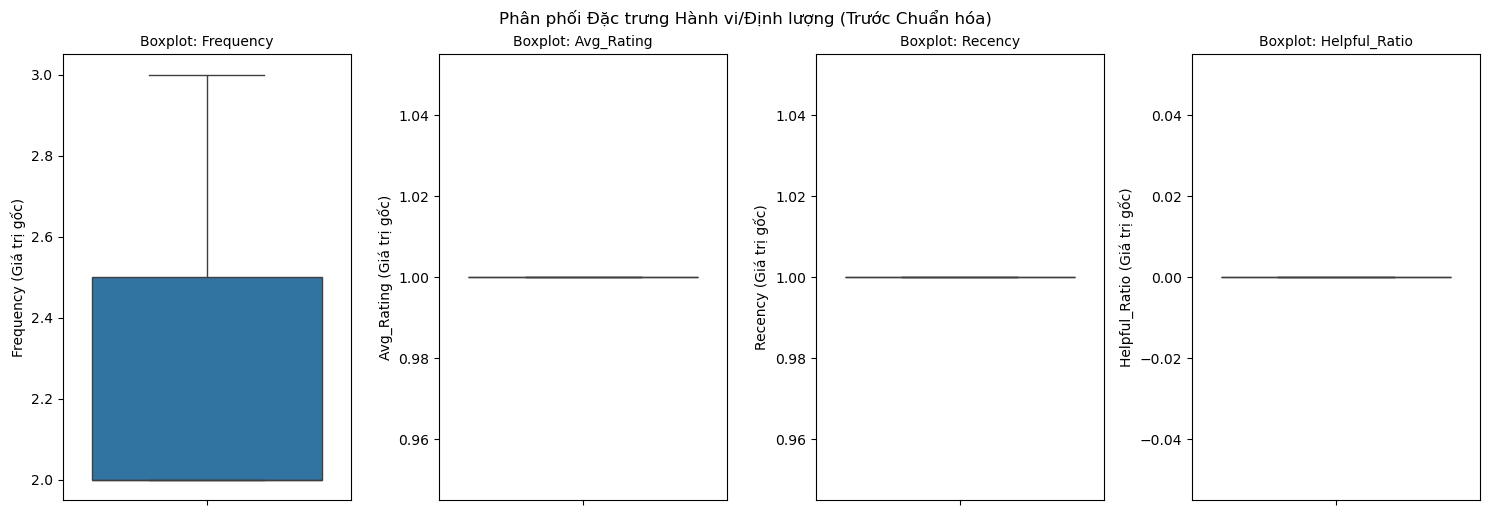

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# KHÔNG sử dụng cột Category_Clean vì nó đã bị xóa trong Bước 3.
# Thay vào đó, chúng ta sẽ tạo lại Series danh mục trước khi xóa, hoặc đơn giản là vẽ biểu đồ các cột số học.
# Tuy nhiên, nếu bạn chạy code Bước 3 ở trên, cột 'Category_Clean' vẫn bị xóa.

# CÁCH XỬ LÝ TỐT NHẤT: TRƯỚC KHI CHẠY CODE NÀY, BẠN CẦN CHẠY BƯỚC 3 ĐÃ SỬA ĐỔI, NƠI CỘT CATEGORY_CLEAN KHÔNG BỊ XÓA.
# Hoặc, bạn phải sửa Bước 3 để lưu cột 'Category_Clean' vào một biến riêng trước khi xóa.

# Giả sử bạn đã CHỈ TẠM THỜI không xóa cột 'Category_Clean' và 'Most_Frequent_Category' ở Bước 3 để vẽ biểu đồ này

# Trực quan hóa Boxplot
numerical_cols = ['Frequency', 'Avg_Rating', 'Recency', 'Helpful_Ratio']
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=user_features[col]) 
    plt.title(f'Boxplot: {col}', fontsize=10)
    plt.ylabel(f'{col} (Giá trị gốc)')
    plt.tight_layout()
plt.suptitle('Phân phối Đặc trưng Hành vi/Định lượng (Trước Chuẩn hóa)', y=1.02)
plt.show()

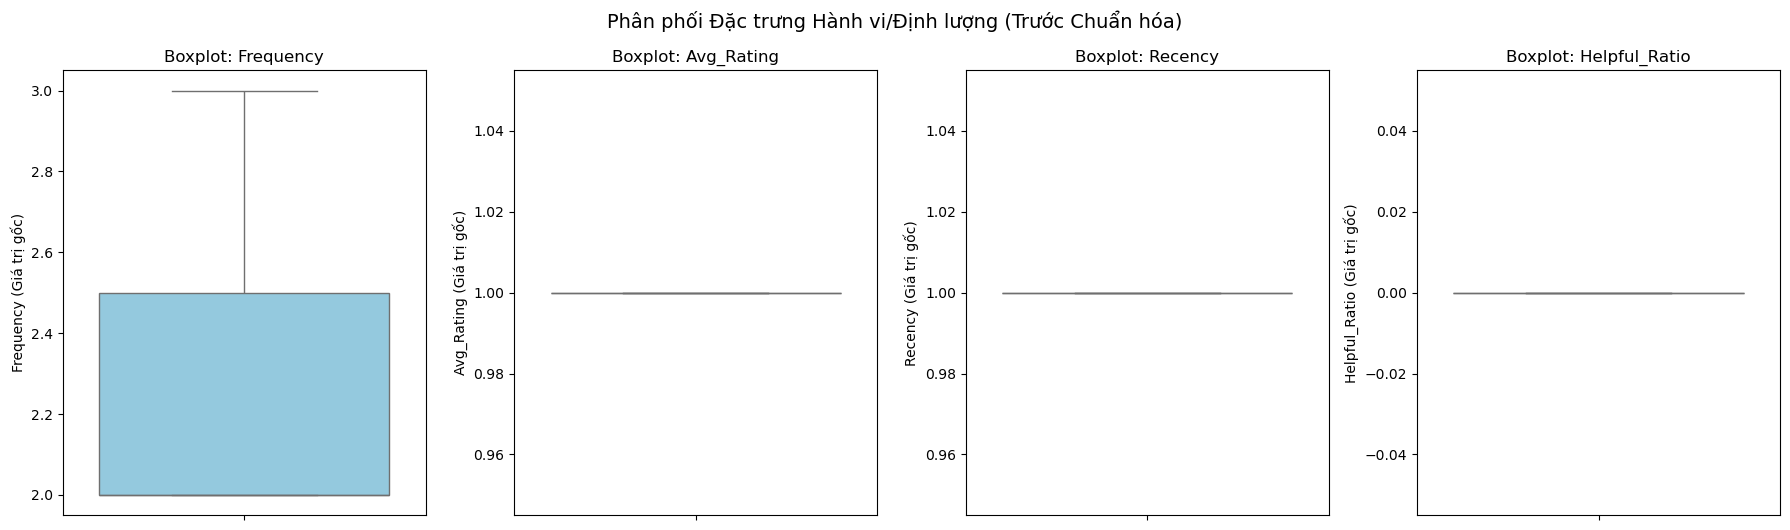

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn các cột số học chính
numerical_cols = ['Frequency', 'Avg_Rating', 'Recency', 'Helpful_Ratio']

plt.figure(figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i + 1)
    # Boxplot hiển thị Q1, Median, Q3 và các giá trị ngoại lai
    sns.boxplot(y=user_features[col], color='skyblue') 
    plt.title(f'Boxplot: {col}', fontsize=12)
    plt.ylabel(f'{col} (Giá trị gốc)')
    plt.tight_layout()
plt.suptitle('Phân phối Đặc trưng Hành vi/Định lượng (Trước Chuẩn hóa)', y=1.05, fontsize=14)
plt.show()

# B. Biểu đồ cho Đặc trưng Phân loại (Category)
Bar Plot Phân bố Danh mục
Lưu ý: Nếu bạn đã chạy Bước 3 ở trên, cột Category_Clean đã bị xóa. Để vẽ biểu đồ này, bạn cần chạy lại Bước 3 nhưng không xóa cột Category_Clean và Most_Frequent_Category hoặc chạy phần code tạo cột đó lại trước khi vẽ.

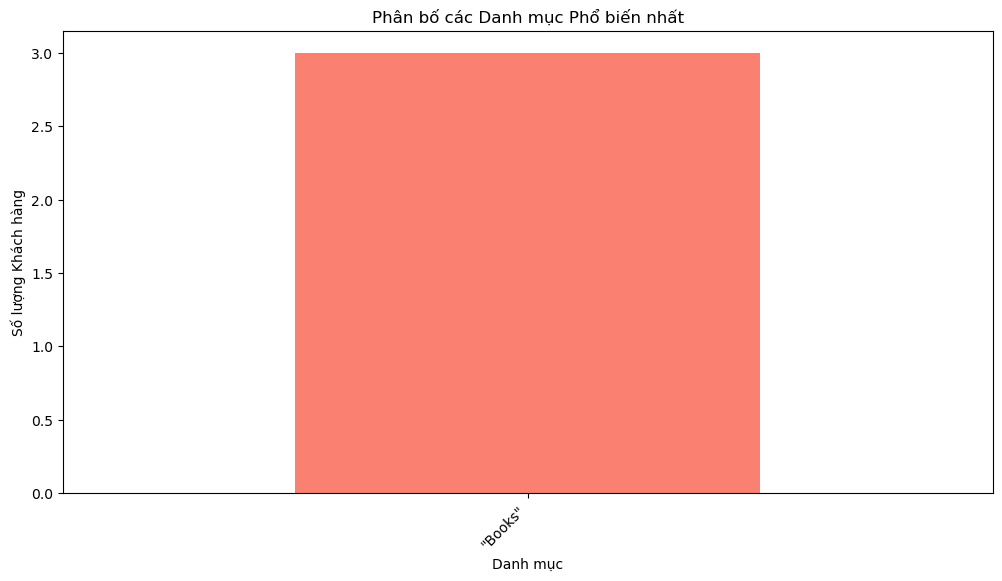

In [102]:
# Vẽ phân bố danh mục (an toàn nếu cột Most_Frequent_Category đã bị xóa trước đó)
# Nếu cột gốc đã bị xóa, ta tái tạo Most_Frequent_Category từ df gốc bằng mode trên product_category.

try:
    # Nếu không tồn tại, tái tạo cột Most_Frequent_Category từ df gốc
    if 'Most_Frequent_Category' not in user_features.columns:
        # Lấy mode của product_category theo customer_id từ df (bản gốc của các review)
        most_freq = df.groupby('customer_id')['product_category'].agg(
            lambda x: x.mode().iat[0] if not x.mode().empty else 'Other'
        ).rename('Most_Frequent_Category')
        # ghép vào user_features dựa trên customer_id
        user_features = user_features.merge(most_freq.reset_index(), on='customer_id', how='left')
    else:
        # đảm bảo biến user_features có cột Most_Frequent_Category
        pass

    # Tạo cột tạm Category_Clean_Temp dựa trên top N categories
    N_CATEGORIES = 15
    top_categories = user_features['Most_Frequent_Category'].value_counts().nlargest(N_CATEGORIES).index.tolist()
    user_features['Category_Clean_Temp'] = user_features['Most_Frequent_Category'].apply(
         lambda x: x if x in top_categories else 'Other'
    )

    plt.figure(figsize=(12, 6))
    user_features['Category_Clean_Temp'].value_counts().plot(kind='bar', color='salmon')
    plt.title('Phân bố các Danh mục Phổ biến nhất')
    plt.xlabel('Danh mục')
    plt.ylabel('Số lượng Khách hàng')
    plt.xticks(rotation=45, ha='right')
    plt.show()

finally:
    # Xóa cột tạm thời sau khi vẽ (và không phá vỡ user_features nếu chưa có)
    user_features.drop(columns=['Category_Clean_Temp'], inplace=True, errors='ignore')

## **4. Chuẩn hóa và Biểu diễn Dữ liệu (TF-IDF)**
# A. Vector hóa TF-IDF

In [103]:
# Sử dụng TF-IDF với điều chỉnh thông minh cho min_df / max_df khi số tài liệu nhỏ
# GIẢM MIN_DF TỐI ĐA ĐỂ TRÁNH LỖI XUNG ĐỘT
MIN_DOCUMENT_FREQUENCY = 1 # Đảm bảo giữ lại các từ xuất hiện ít nhất 1 lần
MAX_DOCUMENT_FREQUENCY = 0.95 
MAX_FEATURES_NLP = 250 


# Số tài liệu thực tế
n_docs = len(user_features['Full_Cleaned_Text'])
print(f"Number of documents for TF-IDF: {n_docs}")

# Sao lưu tham số ban đầu để thông báo khi cần điều chỉnh
min_df_param = MIN_DOCUMENT_FREQUENCY
max_df_param = MAX_DOCUMENT_FREQUENCY

# Nếu min_df là count (>=1) và max_df là tỉ lệ (<1),
# kiểm tra xem max_df tương ứng với bao nhiêu tài liệu và điều chỉnh nếu xung đột.
if isinstance(min_df_param, int) and min_df_param >= 1 and 0 < max_df_param < 1:
    max_df_count = int(np.floor(max_df_param * n_docs))
    # đảm bảo ít nhất 1 document cho max_df_count, ngược lại coi như không giới hạn (1.0)
    if max_df_count < 1:
        print(f"Warning: max_df ({max_df_param}) -> {max_df_count} documents is too small for n_docs={n_docs}. Setting max_df to 1.0 (no upper filtering).")
        max_df_param = 1.0
    elif max_df_count < min_df_param:
        # điều chỉnh min_df xuống để không vượt quá max_df_count
        new_min = max(1, max_df_count)
        print(f"Warning: max_df ({max_df_param}) corresponds to {max_df_count} docs < min_df ({min_df_param}). Adjusting min_df -> {new_min}.")
        min_df_param = new_min

# Nếu cả hai là số nguyên (count) nhưng min_df > n_docs, giảm min_df
if isinstance(min_df_param, int) and min_df_param > n_docs:
    new_min = max(1, n_docs)
    print(f"Warning: min_df ({min_df_param}) > n_docs ({n_docs}). Adjusting min_df -> {new_min}.")
    min_df_param = new_min

# Tạo vectorizer với các tham số đã điều chỉnh
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES_NLP,
    min_df=min_df_param,
    max_df=max_df_param
)

# Áp dụng TF-IDF lên cột văn bản ĐÃ LÀM SẠCH và HỢP NHẤT
tfidf_matrix = tfidf_vectorizer.fit_transform(user_features['Full_Cleaned_Text']).toarray()
tfidf_df = pd.DataFrame(
    tfidf_matrix,
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
)

print(f"\nBước 4.A Hoàn tất: Đã tạo Vector TF-IDF với {tfidf_matrix.shape[1]} chiều.")

Number of documents for TF-IDF: 3

Bước 4.A Hoàn tất: Đã tạo Vector TF-IDF với 25 chiều.


# B. Chuẩn hóa và Hợp nhất Ma trận Cuối cùng

In [104]:
# 1. Chuẩn hóa (Scaling) các cột số học
scaling_cols = ['Frequency', 'Avg_Rating', 'Recency', 'Helpful_Ratio']
scaler = MinMaxScaler()
user_features[scaling_cols] = scaler.fit_transform(user_features[scaling_cols])

# 2. Tạo Ma trận Đặc trưng Cuối cùng X_clustering
structural_features = scaling_cols + [col for col in user_features.columns if col.startswith('Cat_')]
df_structural = user_features[structural_features]

# Ghép nối Vector Cấu trúc và Vector Sở thích (TF-IDF)
df_final_features = pd.concat([df_structural.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Ma trận đầu vào cuối cùng
X_clustering = df_final_features.values
customer_ids = user_features['customer_id'].copy()

print("\nBước 4.B: Tiền xử lý Hoàn tất")
print(f"Kích thước Ma trận Đầu vào X_clustering: {X_clustering.shape}")
print(f"Sẵn sàng cho thuật toán phân cụm.")


Bước 4.B: Tiền xử lý Hoàn tất
Kích thước Ma trận Đầu vào X_clustering: (3, 30)
Sẵn sàng cho thuật toán phân cụm.


# Boxplot sau khi Chuẩn hóa (Scaling)

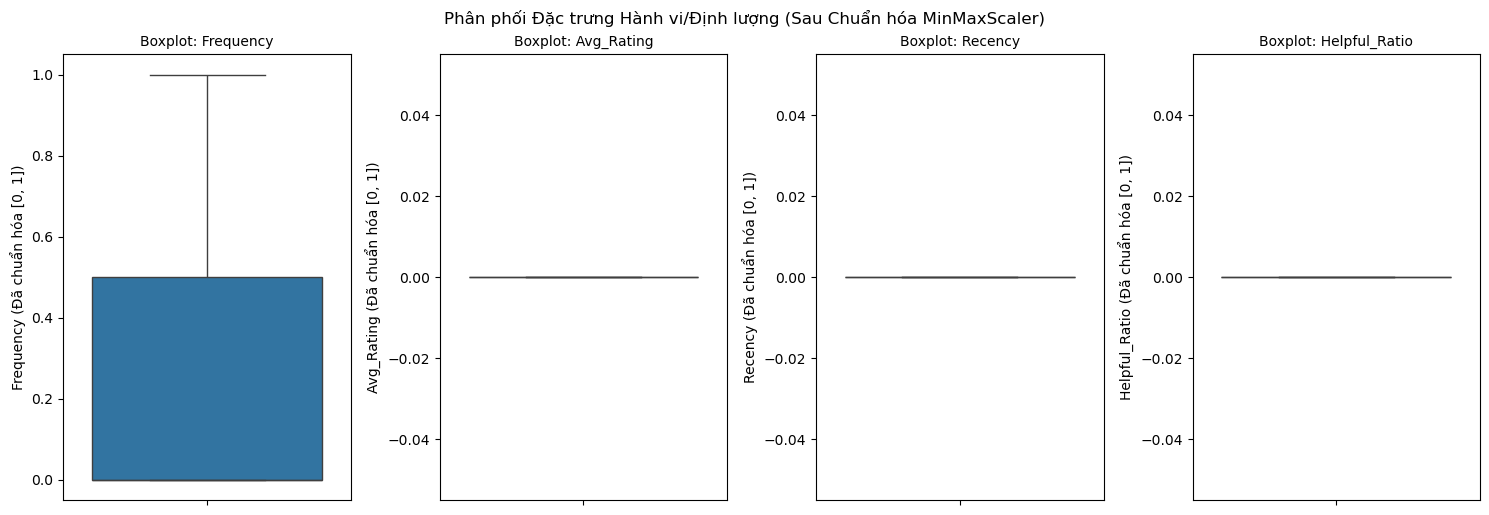

In [105]:
# Cột đã được chuẩn hóa (đã được thay thế trong user_features ở Bước 4)
scaled_cols = ['Frequency', 'Avg_Rating', 'Recency', 'Helpful_Ratio']
df_scaled = user_features[scaled_cols] 

plt.figure(figsize=(15, 5))
for i, col in enumerate(scaled_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df_scaled[col]) 
    plt.title(f'Boxplot: {col}', fontsize=10)
    plt.ylabel(f'{col} (Đã chuẩn hóa [0, 1])') 
    plt.tight_layout()
plt.suptitle('Phân phối Đặc trưng Hành vi/Định lượng (Sau Chuẩn hóa MinMaxScaler)', y=1.02)
plt.show()